In [132]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        file_features = single_img_features(image, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5), scale = 1.5):
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    #print("slide_window {}".format(len(window_list)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy



In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
#from lesson_functions import *

dist_pickle = pickle.load( open("svc_pickle_nice.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
spatial_feat = dist_pickle["spatial_feat"]
hist_feat  = dist_pickle["hist_feat"] 
hog_feat = dist_pickle["hog_feat"] 
y_start_stop = dist_pickle["y_start_stop"] 

print(orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, spatial_feat, hist_feat, hog_feat, y_start_stop)

9 8 2 (32, 32) 32 True True True [400, 656]


In [4]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    i = 0
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        filename = "./data/video/{}.png".format(i)
        i += 1
        #mpimg.imsave(filename, test_img, format='png')
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [5]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def heat_pipe(frame, box_list, threshold = 1):
    heat = np.zeros_like(frame[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, box_list)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    return labels


In [67]:
class Config_Parameters():
    def __init__(self):
        self.svc = None
        self.X_scaler = None
        self.color_space = "YCrCb"
        self.spatial_size = (32, 32)
        self.hist_bins = 32
        self.orient = 9
        self.pix_per_cell = 8
        self.cell_per_block = 2
        self.hog_channel = "ALL"
        self.spatial_feat = True
        self.hist_feat = True
        self.hog_feat = True
        self.windows_64p = True
        self.windows_90p = True
        self.windows_120p = True
        self.heat_threshold = 1
        self.x_start_stop = [None, None]
        self.y_start_stop = [400, 656]
    

In [7]:
cfg = Config_Parameters()
cfg.svc = svc
cfg.X_scaler = X_scaler

In [130]:
def find_car_in_image(frame, cfg, scale255 = True, heat_threshold = 0):
    draw_image = np.copy(frame)
    image = frame
    if scale255 : 
        image = image.astype(np.float32)/255
    if cfg.windows_64p :
        windows_64p = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                                   xy_window=(64, 64), xy_overlap=(0.7, 0.7))
    if cfg.windows_90p :
        windows_90p = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                                   xy_window=(90, 90), xy_overlap=(0.7, 0.7))
    if cfg.windows_120p :
        windows_130p = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                                    xy_window=(130, 130), xy_overlap=(0.7, 0.7))

    #if cfg.windows_120p :
    windows_160p = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                                    xy_window=(150, 150), xy_overlap=(0.7, 0.7))


    windows = windows_64p + windows_90p + windows_130p + windows_160p
    
    hot_windows = search_windows(image, windows, cfg.svc, cfg.X_scaler, color_space=cfg.color_space, 
                        spatial_size=cfg.spatial_size, hist_bins=cfg.hist_bins, 
                        orient=cfg.orient, pix_per_cell=cfg.pix_per_cell, 
                        cell_per_block=cfg.cell_per_block, 
                        hog_channel=cfg.hog_channel, spatial_feat=cfg.spatial_feat, 
                        hist_feat=cfg.hist_feat, hog_feat=cfg.hog_feat)      
    #print(hot_windows)
    labels = heat_pipe(image, hot_windows, heat_threshold)
    #print(labels)
#     if scale255 : 
#         image = image.astype(np.float32)*255
    window_img = draw_labeled_bboxes(draw_image, labels)                    

    return window_img



In [125]:
images = []
import os
orig_frame_out = './orig_frames/'
#orig_frame_out = './samples/'
print(orig_frame_out)
output_frame = './frames_out1/'
files = os.listdir(orig_frame_out)

#for i in range(500, 520) : #len(files)):
for i in range(260, 280) : #len(files)):
    filename = '{}images{}.jpg'.format(orig_frame_out, i)
    my_frame = mpimg.imread(filename)
    my_frame = find_car_in_image(my_frame, cfg, scale255 = True, heat_threshold = 0)
    images.append(my_frame)
    
    my_frame = cv2.cvtColor(my_frame, cv2.COLOR_RGB2BGR)
    output_filename = output_frame + 'frame_{0:0>3}.jpg'.format(i)
    cv2.imwrite(output_filename, my_frame)
    
    if(i % 50 == 0 ) :
        print("processing frame", i)

print("done with video frames")

./orig_frames/
[((1026, 400), (1116, 490)), ((1053, 400), (1143, 490)), ((1161, 427), (1251, 517)), ((1188, 427), (1278, 517)), ((1014, 400), (1144, 530)), ((1131, 400), (1261, 530))]
[((1026, 400), (1116, 490)), ((1053, 400), (1143, 490)), ((1161, 400), (1251, 490)), ((1161, 427), (1251, 517)), ((1188, 427), (1278, 517)), ((1014, 400), (1144, 530)), ((1131, 400), (1261, 530))]
[((1026, 400), (1116, 490)), ((1053, 400), (1143, 490)), ((1161, 427), (1251, 517)), ((1188, 427), (1278, 517)), ((1014, 400), (1144, 530)), ((1131, 400), (1261, 530))]
[((1026, 400), (1116, 490)), ((1161, 400), (1251, 490)), ((1161, 427), (1251, 517)), ((1188, 427), (1278, 517)), ((1014, 400), (1144, 530)), ((1131, 400), (1261, 530))]
[((1197, 438), (1261, 502)), ((1026, 400), (1116, 490)), ((1053, 400), (1143, 490)), ((1161, 427), (1251, 517)), ((1188, 427), (1278, 517)), ((1014, 400), (1144, 530)), ((1131, 400), (1261, 530))]
[((1026, 400), (1116, 490)), ((1053, 400), (1143, 490)), ((1134, 427), (1224, 517)),

In [126]:
import imageio

#imageio.plugins.ffmpeg.download()

from moviepy.editor import ImageSequenceClip

video_file = 'vehicle_detection_2.mp4'
print("Creating video {}, FPS={}".format(video_file, 30))
clip = ImageSequenceClip(images, fps=30)
clip.write_videofile(video_file)

Creating video vehicle_detection_2.mp4, FPS=30
[MoviePy] >>>> Building video vehicle_detection_2.mp4
[MoviePy] Writing video vehicle_detection_2.mp4


 95%|█████████▌| 20/21 [00:00<00:00, 46.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: vehicle_detection_2.mp4 



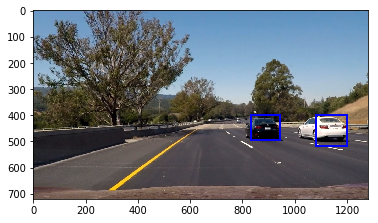

In [75]:
#image = mpimg.imread('bbox-example-image.jpg')
image = mpimg.imread('./test_images/test6.jpg')
draw_image = np.copy(image)
#print(image)
#
color_space = 'YCrCb'
hog_channel = "ALL"

image = image.astype(np.float32)/255

windows_64p = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))

windows_90p = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(90, 90), xy_overlap=(0.5, 0.5))


windows_120p = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(120, 120), xy_overlap=(0.5, 0.5))

windows = windows_64p + windows_120p + windows_90p

#print(windows_64p)
#print(windows_120p)
hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

labels = heat_pipe(image, hot_windows, 1)
#print(labels)
window_img = draw_labeled_bboxes(draw_image, labels)                    


%matplotlib inline
plt.imshow(window_img)

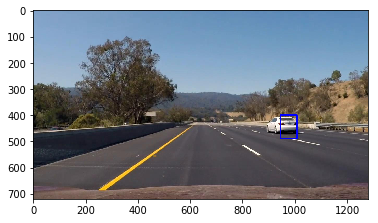

In [97]:
%matplotlib inline
image = mpimg.imread('./samples/images500.jpg')
#print(image)
image = find_car_in_image(image, cfg, scale255 = True, heat_threshold = 2)
#print("cover", image)
#image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
plt.imshow(image)

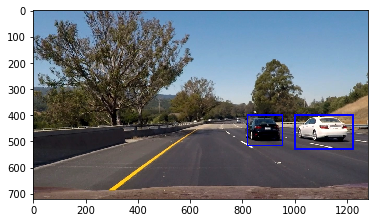

In [98]:
image = mpimg.imread('./test_images/test6.jpg')

image = find_car_in_image(image, cfg, scale255 = True, heat_threshold = 2)
plt.imshow(image)

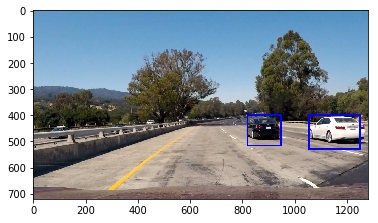

In [99]:
image = mpimg.imread('./test_images/test1.jpg')

image = find_car_in_image(image, cfg, scale255 = True, heat_threshold = 2)
plt.imshow(image)

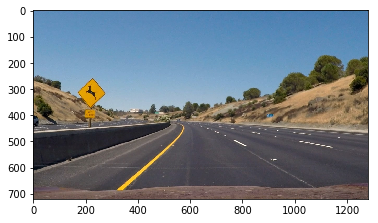

In [84]:
image = mpimg.imread('./test_images/test2.jpg')

image = find_car_in_image(image, cfg, scale255 = True, heat_threshold = 2)
plt.imshow(image)

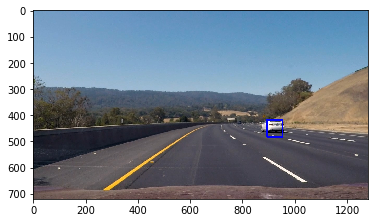

In [100]:
image = mpimg.imread('./test_images/test3.jpg')

image = find_car_in_image(image, cfg, scale255 = True, heat_threshold = 2)
plt.imshow(image)

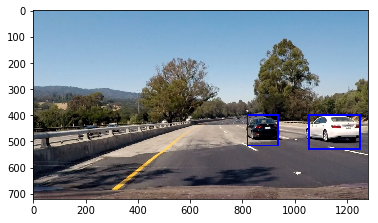

In [101]:
image = mpimg.imread('./test_images/test4.jpg')

image = find_car_in_image(image, cfg, scale255 = True, heat_threshold = 2)
plt.imshow(image)

[((855, 400), (919, 464)), ((874, 400), (938, 464)), ((817, 419), (881, 483)), ((855, 419), (919, 483)), ((874, 419), (938, 483)), ((874, 438), (938, 502)), ((324, 400), (414, 490)), ((783, 400), (873, 490)), ((810, 400), (900, 490)), ((837, 400), (927, 490)), ((864, 400), (954, 490)), ((999, 400), (1089, 490)), ((1107, 400), (1197, 490)), ((0, 427), (90, 517)), ((837, 427), (927, 517)), ((864, 427), (954, 517)), ((1107, 427), (1197, 517)), ((486, 454), (576, 544)), ((594, 454), (684, 544)), ((819, 400), (949, 530)), ((1092, 400), (1222, 530)), ((1131, 400), (1261, 530))]


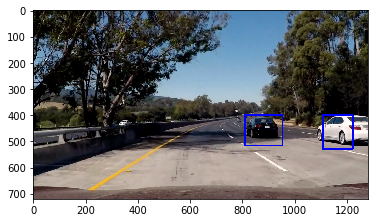

In [115]:
cfg5 = Config_Parameters()
cfg5.svc = svc
cfg5.X_scaler = X_scaler

image = mpimg.imread('./test_images/test5.jpg')

image = find_car_in_image(image, cfg5, scale255 = True, heat_threshold = 1)
plt.imshow(image)

[((1026, 400), (1116, 490)), ((1053, 400), (1143, 490)), ((1161, 427), (1251, 517)), ((1188, 427), (1278, 517)), ((1014, 400), (1144, 530)), ((1131, 400), (1261, 530))]


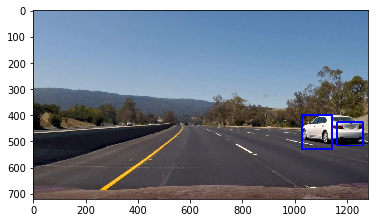

In [116]:
image = mpimg.imread('./orig_frames/images260.jpg')

image = find_car_in_image(image, cfg, scale255 = True, heat_threshold = 1)
plt.imshow(image)

[((864, 400), (954, 490))]


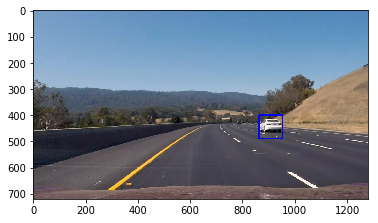

In [135]:
image = mpimg.imread('./orig_frames/images664.jpg')

image = find_car_in_image(image, cfg, scale255 = True, heat_threshold = 0)
plt.imshow(image)

(32, 32)
32
9 8 2


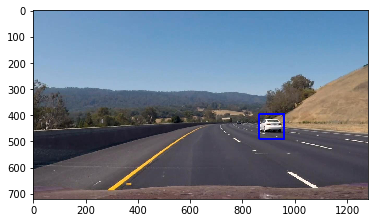

In [137]:
import numpy as np
import cv2
from skimage.feature import hog

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    bbox_list = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #print(spatial_features.shape, hist_features.shape, hog_features.shape)
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                                 
    return draw_img, bbox_list

#img = mpimg.imread('test_image.jpg')
#img = mpimg.imread('./test_images/test1.jpg')
image = mpimg.imread('./orig_frames/images664.jpg')

print(spatial_size)   
print(hist_bins)
print( orient, pix_per_cell, cell_per_block)
ystart = 395
ystop = 656
scale = 1.5
    
out_img, box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)

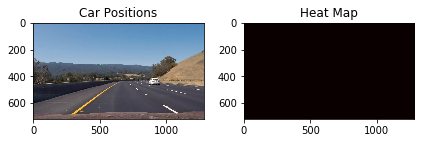

In [141]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
#box_list = pickle.load( open( "bbox_pickle.p", "rb" ))

# Read in image similar to one shown above 
#image = mpimg.imread('test_image.jpg')
#image = mpimg.imread('./test_images/test1.jpg')
image = mpimg.imread('./orig_frames/images664.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()